In [1]:
TRAINING_SET_SIZE = 5000

In [23]:
! pip3 install matplotlib
! pip3 install tensorflow-addons
! pip3 install pandas
! pip3 install pendulum
import os
import pendulum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from residualmlp.residual_mlp import ResidualMLP

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 50
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

y_train_ohe = tf.one_hot([i[0] for i in y_train], 10)
indexes_for_rows = tf.range(0, y_train.shape[0])
shuffled_indexes = tf.random.shuffle(indexes_for_rows)
selected_indexes = shuffled_indexes[:TRAINING_SET_SIZE]
selected_x_train = x_train[selected_indexes, :, :, :]
selected_y_train_ohe = y_train_ohe.numpy()[selected_indexes, :]

170508288/170498071 [==============================] - 8s 0us/step


2022-01-14 02:34:47.266593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:34:47.429953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:34:47.430946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:34:47.437350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:34:47.438287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

2022-01-14 02:35:00.827058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(-0.5, 31.5, 31.5, -0.5)

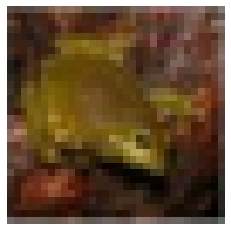

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

In [8]:


resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


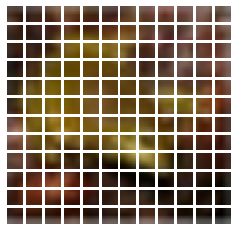

In [9]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [30]:
def create_vit_classifier(vit_base_model_input_shape = (32, 32, 3)):
    
    inputs = layers.Input(shape=vit_base_model_input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # x3 = residual_mlp
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    #features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    
    temp_model = keras.Model(inputs=inputs, outputs=representation)
    return temp_model
    
    #model = keras.Model(inputs=inputs, outputs=logits)
    #return model

In [31]:
base_vit_model = create_vit_classifier()

In [34]:
base_vit_model(x_train[:5])  # (tf.keras.layers.Resizing(600,600)(x_train[:5]))

<tf.Tensor: shape=(5, 9216), dtype=float32, numpy=
array([[-0.8751941 , -0.46437943, -0.2800613 , ...,  0.5446826 ,
         1.058563  ,  0.8120527 ],
       [-0.9375937 , -0.16988102,  0.15574908, ...,  0.63439095,
         0.16924012,  0.62020636],
       [ 1.7343085 , -1.6072178 ,  0.2988301 , ..., -0.98894274,
        -0.35334945, -1.1284822 ],
       [-0.9013183 ,  0.10158834, -0.47234935, ..., -0.0764176 ,
         0.22021341, -0.04076746],
       [ 1.6004786 , -0.69699466,  0.46108472, ...,  0.32532746,
         0.10673958, -0.64593303]], dtype=float32)>

In [45]:
res_mlp = ResidualMLP(problem_type = 'classification', #
                      learning_rate = .0007, #
                      input_shape = (32, 32, 3), #(32,32,3), #
                      bw_images = False, #
                      base_model = base_vit_model, #
                      base_model_input_shape = (32, 32, 3),  # (600,600,3), #
                      flatten_after_base_model = True, #
                      blocks = [[7, 75, 8], [5, 75, 10]], #
                      residual_bypass_dense_layers = [[5],[5]], #
                      b_norm_or_dropout_residual_bypass_layers = 'dropout', #
                      dropout_rate_for_bypass_layers = .7, #
                      inter_block_layers_per_block = list(),
                      b_norm_or_dropout_last_layers = 'dropout', # | 'bnorm'
                      dropout_rate = .18, #
                      activation = tf.keras.activations.relu, #
                      final_dense_layers = [], #
                      number_of_classes = 10, # 1 if a regression problem
                      # final_activation = tf.keras.activations.softmax, #
                      #loss = tf.keras.losses.CategoricalCrossentropy(
                      #    from_logits=False)
                     )
final_residual_mlp = res_mlp.make_tandem_model()

In [46]:
final_residual_mlp.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resizing_7 (Resizing)           (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
model_3 (Functional)            (None, 9216)         681927      resizing_7[0][0]                 
__________________________________________________________________________________________________
dense_136 (Dense)               (None, 75)           691275      model_3[2][0]                    
____________________________________________________________________________________________

In [47]:
# Let's verify that this beast can accept inputs and return a valid response ...

final_residual_mlp(x_train[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.09813619, 0.09499165, 0.09484421, 0.10562367, 0.10873424,
        0.09120164, 0.1036211 , 0.10537623, 0.10196073, 0.09551035],
       [0.08977162, 0.08896089, 0.09125815, 0.10686424, 0.11868942,
        0.08845071, 0.10873959, 0.11313656, 0.1047997 , 0.08932914],
       [0.09854777, 0.08676405, 0.09808405, 0.11524292, 0.11145621,
        0.08330224, 0.10447336, 0.1086699 , 0.10480973, 0.08864973],
       [0.09826165, 0.09115399, 0.09172916, 0.10651731, 0.11118338,
        0.09137189, 0.10408428, 0.10874061, 0.10170583, 0.09525184],
       [0.09960499, 0.0944493 , 0.09919249, 0.10596287, 0.10688185,
        0.08963875, 0.10353771, 0.10481767, 0.10242791, 0.09348646]],
      dtype=float32)>

In [48]:

date = pendulum.now().__str__()[:16].replace("T","_").replace(":","_")

RESULTS_DIR = f'vit-ResidualMLP-image-classifier_{date}'
PATIENCE = 25
PATIENCE_MIN_DELTA = 0.00001
BATCH_SIZE = 50
EPOCHS = 100

logdir = os.path.join("logs", RESULTS_DIR + "_TB")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = final_residual_mlp.fit(
    x=selected_x_train,
    y=selected_y_train_ohe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose="auto",
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=PATIENCE,
            min_delta=PATIENCE_MIN_DELTA,
            restore_best_weights=True,
        ),
        tensorboard_callback,
    ],
    validation_split=0.3,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=10,
    validation_freq=1,
    max_queue_size=10,
    workers=5,
    use_multiprocessing=True,
)

2022-01-14 02:59:03.220152: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-14 02:59:03.220205: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2022-01-14 02:59:03.394872: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-14 02:59:03.395117: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


Epoch 1/100
 1/70 [..............................] - ETA: 15:11 - loss: 2.9789 - top_1_categorical_accuracy: 0.1400 - top_2_categorical_accuracy: 0.2000 - top_3_categorical_accuracy: 0.3000 - top_4_categorical_accuracy: 0.3800 - top_5_categorical_accuracy: 0.6400 - top_6_categorical_accuracy: 0.7400 - top_7_categorical_accuracy: 0.8200 - top_8_categorical_accuracy: 0.8600 - top_9_categorical_accuracy: 0.9200 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - accuracy: 0.0000e+00

2022-01-14 02:59:17.091862: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-14 02:59:17.091927: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/70 [..............................] - ETA: 44s - loss: 3.0962 - top_1_categorical_accuracy: 0.1400 - top_2_categorical_accuracy: 0.2000 - top_3_categorical_accuracy: 0.2800 - top_4_categorical_accuracy: 0.3600 - top_5_categorical_accuracy: 0.5600 - top_6_categorical_accuracy: 0.6800 - top_7_categorical_accuracy: 0.7900 - top_8_categorical_accuracy: 0.8300 - top_9_categorical_accuracy: 0.9200 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - accuracy: 0.0000e+00  

2022-01-14 02:59:18.199783: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-14 02:59:18.206401: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-14 02:59:18.275849: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4410 callback api events and 4440 activity events. 
2022-01-14 02:59:18.406061: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-14 02:59:18.566501: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18

2022-01-14 02:59:18.645255: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18/ni3hlwjucf.trace.json.gz
2022-01-14 02:59

 4/70 [>.............................] - ETA: 51s - loss: 3.3507 - top_1_categorical_accuracy: 0.1150 - top_2_categorical_accuracy: 0.1750 - top_3_categorical_accuracy: 0.2750 - top_4_categorical_accuracy: 0.3600 - top_5_categorical_accuracy: 0.5050 - top_6_categorical_accuracy: 0.6200 - top_7_categorical_accuracy: 0.7400 - top_8_categorical_accuracy: 0.8100 - top_9_categorical_accuracy: 0.9100 - precision_4: 0.0417 - recall_4: 0.0100 - accuracy: 0.0000e+00      

2022-01-14 02:59:18.851169: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18/ni3hlwjucf.memory_profile.json.gz
2022-01-14 02:59:18.863306: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18
Dumped tool data for xplane.pb to logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18/ni3hlwjucf.xplane.pb
Dumped tool data for overview_page.pb to logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18/ni3hlwjucf.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/vit-ResidualMLP-image-classifier_2022-01-14_02_59_TB/train/plugins/profile/2022_01_14_02_59_18/ni3hlwjucf.input_pipeline.pb
Dumped tool data fo

70/70 [==============================] - 22s 122ms/step - loss: 3.2680 - top_1_categorical_accuracy: 0.1103 - top_2_categorical_accuracy: 0.2229 - top_3_categorical_accuracy: 0.3149 - top_4_categorical_accuracy: 0.4160 - top_5_categorical_accuracy: 0.5211 - top_6_categorical_accuracy: 0.6123 - top_7_categorical_accuracy: 0.7137 - top_8_categorical_accuracy: 0.8109 - top_9_categorical_accuracy: 0.9040 - precision_4: 0.0949 - recall_4: 0.0166 - accuracy: 0.0000e+00 - val_loss: 2.3114 - val_top_1_categorical_accuracy: 0.0847 - val_top_2_categorical_accuracy: 0.1953 - val_top_3_categorical_accuracy: 0.3067 - val_top_4_categorical_accuracy: 0.4113 - val_top_5_categorical_accuracy: 0.5120 - val_top_6_categorical_accuracy: 0.6127 - val_top_7_categorical_accuracy: 0.7093 - val_top_8_categorical_accuracy: 0.8020 - val_top_9_categorical_accuracy: 0.8920 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
70/70 [==============================] - 5s 70ms

In [51]:
hy = pd.DataFrame(history.history)

In [52]:
hy

,loss,top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy,top_4_categorical_accuracy,top_5_categorical_accuracy,top_6_categorical_accuracy,top_7_categorical_accuracy,top_8_categorical_accuracy,top_9_categorical_accuracy,...,val_top_3_categorical_accuracy,val_top_4_categorical_accuracy,val_top_5_categorical_accuracy,val_top_6_categorical_accuracy,val_top_7_categorical_accuracy,val_top_8_categorical_accuracy,val_top_9_categorical_accuracy,val_precision_4,val_recall_4,val_accuracy
0,3.268015,0.110286,0.222857,0.314857,0.416000,0.521143,0.612286,0.713714,0.810857,0.904000,...,0.306667,0.411333,0.512000,0.612667,0.709333,0.802000,0.892000,0.000000,0.000000,0.0
1,2.710025,0.116286,0.218000,0.322571,0.425143,0.534286,0.639714,0.734857,0.825714,0.916857,...,0.298667,0.396000,0.496000,0.594667,0.696000,0.797333,0.892667,0.000000,0.000000,0.0
2,2.530882,0.115143,0.235143,0.339714,0.442000,0.542571,0.641429,0.735429,0.827714,0.913714,...,0.359333,0.476000,0.571333,0.664667,0.760000,0.840000,0.925333,0.000000,0.000000,0.0
3,2.430954,0.126571,0.243143,0.347143,0.454286,0.554286,0.654857,0.745429,0.829714,0.914571,...,0.404000,0.514667,0.611333,0.686667,0.785333,0.863333,0.938000,0.000000,0.000000,0.0
4,2.345432,0.134286,0.264286,0.379429,0.483429,0.586571,0.683143,0.763429,0.855143,0.930571,...,0.476000,0.584000,0.678000,0.765333,0.837333,0.892000,0.964000,0.375000,0.002000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1.356229,0.532571,0.731429,0.829143,0.889429,0.926571,0.949714,0.969429,0.980571,0.992857,...,0.718667,0.800667,0.858000,0.902000,0.938000,0.957333,0.982667,0.542169,0.270000,0.0
88,1.351972,0.525143,0.730857,0.818000,0.884286,0.923143,0.954571,0.969714,0.985143,0.994286,...,0.706667,0.777333,0.848667,0.901333,0.931333,0.958667,0.981333,0.535714,0.270000,0.0
89,1.339727,0.538571,0.736000,0.833143,0.892857,0.932000,0.954000,0.972571,0.986286,0.994571,...,0.723333,0.806667,0.867333,0.906667,0.936000,0.962667,0.986000,0.529338,0.282667,0.0
90,1.308339,0.550571,0.741714,0.837429,0.898857,0.930286,0.955143,0.975429,0.987143,0.995143,...,0.724667,0.810000,0.863333,0.910667,0.940000,0.961333,0.985333,0.537827,0.260667,0.0


In [53]:
hy.to_csv('test_history.csv')

In [54]:
hy.to_json('test_history.json')

In [55]:
hy.columns

Index(['loss', 'top_1_categorical_accuracy', 'top_2_categorical_accuracy',
       'top_3_categorical_accuracy', 'top_4_categorical_accuracy',
       'top_5_categorical_accuracy', 'top_6_categorical_accuracy',
       'top_7_categorical_accuracy', 'top_8_categorical_accuracy',
       'top_9_categorical_accuracy', 'precision_4', 'recall_4', 'accuracy',
       'val_loss', 'val_top_1_categorical_accuracy',
       'val_top_2_categorical_accuracy', 'val_top_3_categorical_accuracy',
       'val_top_4_categorical_accuracy', 'val_top_5_categorical_accuracy',
       'val_top_6_categorical_accuracy', 'val_top_7_categorical_accuracy',
       'val_top_8_categorical_accuracy', 'val_top_9_categorical_accuracy',
       'val_precision_4', 'val_recall_4', 'val_accuracy'],
      dtype='object')

<AxesSubplot:>

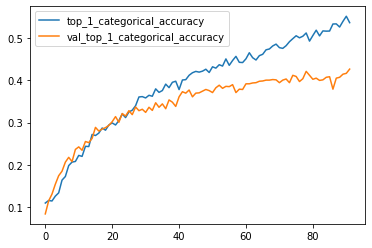

In [56]:
hy[['top_1_categorical_accuracy','val_top_1_categorical_accuracy']].plot()

# This was not a great run, but this is a first pass. Things to try:
1. First try bnorm in the main block of Dense layers. The diminishing gradient over epochs may be a sgn of internal covariate shift.
2. Try a less complex model:
    1. Try fewer layers per block 
    2. Smaller layers in blocks
    3. Less Dense units on residual bypass
3. Optimize learning rate 
4. Start with a suitable pre-trained vision transformer as a base model.